# Using Google Big Transfer (BiT) to generate Image Embeddings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import PIL
from numpy.linalg import norm


from PIL import *
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from src.resnetv2 import ResNetV2, get_headless_model, get_model_weights
from src.img_preprocessing import preprocess_eval, tobaccoDataSet

Big Transfer for image embeddings set-up

In [2]:
# First we download the model weights for BiT-M trained on Imagenet 21k
weights = get_model_weights('BiT-M-R50x1')
# We set up BiT-M with the Imagenet 21k output size number of classes
model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=21843) 
# Reload the model weights 
model.load_from(weights)
# Get final layer prior to classification layer in head
tf_last_layer_chopped = get_headless_model(model)
# Print the model architecture
tf_last_layer_chopped

Sequential(
  (0): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (padp): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (block1): Sequential(
      (unit01): PreActBottleneck(
        (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (downsample): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (unit02): PreActBottleneck(
        (gn1): GroupNorm(32, 256, eps=1e-05, affine

Initiate the [Tobacco 800](http://tc11.cvc.uab.es/datasets/Tobacco800_1) Dataset

In [15]:
tobacco_dataset = tobaccoDataSet("/home/jovyan/work/BiT-Tobacco-800/data/Tobacco800_SinglePage/SinglePageTIF",
                                           transform=preprocess_eval)
loader_test = torch.utils.data.DataLoader(tobacco_dataset, batch_size=1, shuffle=False, num_workers=2)

In [13]:
tf_last_layer_chopped.eval()

output = []
with torch.no_grad():
    for i, x in enumerate(loader_test):
        logits = tf_last_layer_chopped(x)
        embedding = torch.flatten(logits)
        normalized_features = embedding / norm(embedding)
        output.append(torch.flatten(embedding.detach().numpy())
        

# Exploring Embedding Clustering with Hierarichal Clustering (HDBSCAN)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
k = 10
kmodel = KMeans(n_clusters = k, n_jobs=-1, random_state=728)
kmodel.fit(output)
kpredictions = kmodel.predict(output)
shutil.rmtree(‘output’)
for i in range(k):
    os.makedirs(“output\cluster” + str(i))
for i in range(len(paths)):
    shutil.copy2(paths[i], “output\cluster”+str(kpredictions[i]))


In [ ]:
import hdbscan
from sklearn.manifold import TSNE

In [ ]:
projection_modelling = TSNE(50, method='exact').fit_transform(output)

In [ ]:
projection_visualisation = TSNE(2).fit_transform(output)

In [ ]:
clusterer = hdbscan.HDBSCAN().fit(projection_modelling)

In [ ]:
len(clusterer.labels_)

1290

In [ ]:
clusterer.labels_.max()

19

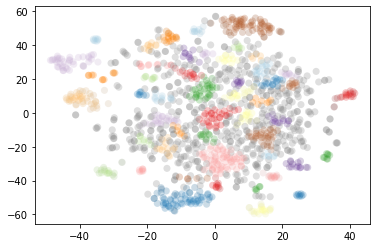

In [ ]:
color_palette = sns.color_palette('Paired', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection_visualisation.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(output_80)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
projection = TSNE().fit_transform(output)
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

NameError: name 'output_80' is not defined

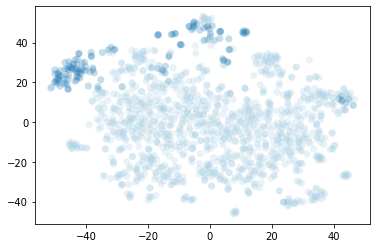

In [ ]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

# Creating an Indexer with FAISS for reverse Image Search

In [ ]:
rom sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])['title']
  
# get the recommendation
recommend_movies(user_embedding)

In [ ]:
type(xb)

numpy.ndarray

In [ ]:
arr = np.array(output)
a = np.float32(arr)

In [ ]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(len(output[0]))   # build the index
print(index.is_trained)
index.add(a)                  # add vectors to the index
print(index.ntotal)

True
1290


# Clustering with FAISS